# 0. Imports and initializations

In [27]:
# for data manipulation
import numpy as np
import pandas as pd

# for data normalization and splitting
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# for models
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import callbacks
from keras.utils.vis_utils import plot_model
import keras_tuner

# for plots
import matplotlib.pyplot as plt

# 1. Next Value Prediction Task

## 1.1 Utility functions

### 1.1.1 <code>features_and_lables</code>
Given the normalized data, the function will produce sequencies of specific window size window shift.

In [28]:
def features_and_labels(data, window_size: int = 30, window_shift: int = 6):
  """
  Given the data, the function will produce sequencies of specific
  window size window shift.
  """
  features = []
  labels = []

  for i in range(window_size, len(data), window_shift):
    features.append(np.reshape(data[i - window_size:i], (1, -1))[0])
    labels.append(data[i])
  features, labels = np.array(features), np.array(labels)

  return features, labels

### 1.1.2 <code>build_model</code>
Given in input the features, the model will be fitted to the input shape. Moreover, this model will have a single output node.

In [29]:
def build_model(features):
  """
  Given in input the features, the model will be fitted to the input shape.
  Moreover, this model will have a single output node.
  Il meno peggio per ora (80,80,80,80,64,64,64,32,1)
  """

  model = models.Sequential()
  model.add(layers.Input((features.shape[1], 1), name='Input'))
  model.add(layers.LSTM(units=80, return_sequences=True, name='LSTM-1'))
  model.add(layers.Dropout(0.2))
  model.add(layers.LSTM(units=80, return_sequences=True, name='LSTM-2'))
  model.add(layers.Dropout(0.2))
  model.add(layers.LSTM(units=80, name='LSTM-3'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(units=80, activation='relu', name='Dense-1'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(units=64, activation='relu', name='Dense-2'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(units=64, activation='relu', name='Dense-3'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(units=64, activation='relu', name='Dense-4'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(units=32, activation='relu', name='Dense-5'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(units=1, name='Dense-final'))
  model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss=losses.mse, metrics=[metrics.mae])

  return model

### 1.1.3 <code>denormalize</code>
Given in input a value and the scaler used for the normalization, the function returns the denormalized value

In [30]:
def denormalize(value: float, scaler: StandardScaler):
  """
  Given in input the mean absolute error and the scaler used for the
  normalization, the function returns the denormalized value
  """
  return (scaler.inverse_transform(np.reshape(np.array([value]), (-1, 1))))[0][0]

### 1.1.4 <code>model_builder</code>
The function is used for searching the best model to be used

In [31]:
def model_builder(hp):
  """
  The function is used for searching the best model to be used
  """

  hp_units_1 = hp.Int('units_1', min_value=32, max_value=256, step=16)  # for LSTMs
  hp_units_2 = hp.Int('units_2', min_value=32, max_value=256, step=16)  # for first dense
  hp_units_3 = hp.Int('units_3', min_value=32, max_value=256, step=16)  # for second dense
  hp_units_4 = hp.Int('units_4', min_value=32, max_value=256, step=16)  # for third dense
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model = models.Sequential()
  model.add(layers.Input((30, 1), name='Input'))
  model.add(layers.LSTM(units=hp_units_1, return_sequences=True, name='LSTM-1'))
  model.add(layers.Dropout(0.2))
  model.add(layers.LSTM(units=hp_units_1, return_sequences=True, name='LSTM-2'))
  model.add(layers.Dropout(0.2))
  model.add(layers.LSTM(units=hp_units_1, name='LSTM-3'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(units=hp_units_2, activation='relu', name='Dense-1'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(units=hp_units_3, activation='relu', name='Dense-2'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(units=hp_units_4, activation='relu', name='Dense-3'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(units=1, name='Dense-final'))
  model.compile(optimizer=optimizers.Adam(learning_rate=hp_learning_rate), loss=losses.mse, metrics=[metrics.mae])

  return model

## 1.2 Fixed windows properties
We have 3 time series (X, Y, Z) recorded each 10 seconds
- Given a sequence of 5 minutes every one minute
- The goal is to predict the next value of the sequence for each time series
- Evaluation Metric: **Mean Absolute Error**


### 1.2.1 Loading the dataset

In [32]:
data = pd.read_csv('dataset_task_1/train.csv')

data.head()

,x,y,z
0,-24,749,-626
1,-206,930,-63
2,-139,763,-577
3,-503,441,-557
4,-278,705,-396


### 1.2.2 Reshaping columns
We separate each column, to process them in a separate way

In [33]:
x_data = np.reshape(data.x.to_numpy(), (-1, 1))
y_data = np.reshape(data.y.to_numpy(), (-1, 1))
z_data = np.reshape(data.z.to_numpy(), (-1, 1))

x_data

array([[ -24],
       [-206],
       [-139],
       ...,
       [ 559],
       [ 559],
       [ 559]])

### 1.2.3 Data preprocessing
We use the function <code>features_and_lables</code>, defined before, that helps with the transformation of data in sequences.

In [34]:
x_features, x_labels = features_and_labels(x_data, window_size=30, window_shift=6)
y_features, y_labels = features_and_labels(y_data, window_size=30, window_shift=6)
z_features, z_labels = features_and_labels(z_data, window_size=30, window_shift=6)

print(x_features[0])
print(x_labels[0])

[ -24 -206 -139 -503 -278  240 -671  -45  102   15  142    3 -176 -768
 -838 -420 -419 -420 -419 -418 -417 -414 -408 -407 -407 -408 -407 -408
 -408 -409]
[-408]


### 1.2.4 Data normalization
We use the standard scaler, in order to normalize values.

In [35]:
x_scaler = StandardScaler()
x_scaler.fit(x_features)
x_features = x_scaler.transform(x_features)

y_scaler = StandardScaler()
y_scaler.fit(y_features)
y_features = y_scaler.transform(y_features)

z_scaler = StandardScaler()
z_scaler.fit(z_features)
z_features = z_scaler.transform(z_features)

x_features[0]

array([-0.31846375, -0.69210742, -0.55333931, -1.29009094, -0.8330969 ,
        0.21812059, -1.63390757, -0.36431967, -0.06244556, -0.23752702,
        0.01981392, -0.26366122, -0.62766428, -1.83661042, -1.97735234,
       -1.12156197, -1.11954163, -1.12352781, -1.12177456, -1.12407862,
       -1.11992643, -1.10946296, -1.09729569, -1.09719701, -1.09747076,
       -1.10380867, -1.09964788, -1.09736257, -1.09738732, -1.10135407])

### 1.2.5 Splitting in training set and validation set

In [36]:
x_train_features, x_val_features, x_train_labels, x_val_labels = train_test_split(x_features, x_labels, test_size=0.2)
y_train_features, y_val_features, y_train_labels, y_val_labels = train_test_split(y_features, y_labels, test_size=0.2)
z_train_features, z_val_features, z_train_labels, z_val_labels = train_test_split(z_features, z_labels, test_size=0.2)

### 1.2.6 Model building
We use the function <code>build_model</code>, defined before, to build a model for each time series.

In [37]:
# x_model = build_model(x_features)
# y_model = build_model(y_features)
# z_model = build_model(z_features)

# x_model.summary()

### 1.2.7 Model fit
We fit the model for each time series.

In [38]:
EPOCHS = 25
BATCH_SIZE = 32

# x_model_checkpoint_callback = callbacks.ModelCheckpoint('task_1/models/x', save_weights_only=True, monitor='val_mean_absolute_error', mode='min', save_best_only=True)
# y_model_checkpoint_callback = callbacks.ModelCheckpoint('task_1/models/y', save_weights_only=True, monitor='val_mean_absolute_error', mode='min', save_best_only=True)
# z_model_checkpoint_callback = callbacks.ModelCheckpoint('task_1/models/z', save_weights_only=True, monitor='val_mean_absolute_error', mode='min', save_best_only=True)

# print('---------- x training epochs ----------')
# x_history = x_model.fit(x_train_features, x_train_labels, validation_data=(x_val_features, x_val_labels), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[x_model_checkpoint_callback])
# print('---------- y training epochs ----------')
# y_history = y_model.fit(y_train_features, y_train_labels, validation_data=(y_val_features, y_val_labels), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[y_model_checkpoint_callback])
# print('---------- z training epochs ----------')
# z_history = z_model.fit(z_train_features, z_train_labels, validation_data=(z_val_features, z_val_labels), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[z_model_checkpoint_callback])

tuner = keras_tuner.Hyperband(model_builder,
                              objective='val_mean_absolute_error',
                              max_epochs=15,
                              factor=3,
                              directory='task_1/tuner',
                              project_name='pippo')

tuner.search(x_train_features, x_train_labels, validation_data=(x_val_features, x_val_labels), epochs=EPOCHS, batch_size=BATCH_SIZE)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

INFO:tensorflow:Reloading Oracle from existing project task_1/tuner/pippo/oracle.json
INFO:tensorflow:Reloading Tuner from task_1/tuner/pippo/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [39]:
print(f"""
The hyperparameter search is complete.
units_1: {best_hps.get('units_1')}
units_2: {best_hps.get('units_2')}
units_3: {best_hps.get('units_3')}
units_4: {best_hps.get('units_4')}
learning_rate: {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete.
units_1: 144
units_2: 176
units_3: 208
units_4: 128
learning_rate: 0.0001.



In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
x_model = tuner.hypermodel.build(best_hps)
x_model.summary()
x_model_checkpoint_callback = callbacks.ModelCheckpoint('task_1/models/x', save_weights_only=True, monitor='val_mean_absolute_error', mode='min', save_best_only=True)
x_history = x_model.fit(x_train_features, x_train_labels, validation_data=(x_val_features, x_val_labels), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[x_model_checkpoint_callback])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM-1 (LSTM)               (None, 30, 144)           84096     
                                                                 
 dropout_24 (Dropout)        (None, 30, 144)           0         
                                                                 
 LSTM-2 (LSTM)               (None, 30, 144)           166464    
                                                                 
 dropout_25 (Dropout)        (None, 30, 144)           0         
                                                                 
 LSTM-3 (LSTM)               (None, 144)               166464    
                                                                 
 dropout_26 (Dropout)        (None, 144)               0         
                                                                 
 Dense-1 (Dense)             (None, 176)              

### 1.2.8 Plotting losses and metrics

In [ ]:
x_loss = x_history.history['loss']
x_val_loss = x_history.history['val_loss']
epochs = range(1, EPOCHS + 1)
plt.plot(epochs, x_loss, 'b', label='x training loss')
plt.plot(epochs, x_val_loss, 'y', label='x validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [ ]:
# y_loss = y_history.history['loss']
# y_val_loss = y_history.history['val_loss']
# epochs = range(1, EPOCHS + 1)
# plt.plot(epochs, y_loss, 'b', label='y training loss')
# plt.plot(epochs, y_val_loss, 'y', label='y validation loss')
# plt.title('Loss')
# plt.xlabel('Epochs')
# plt.ylabel('MSE')
# plt.legend()
# plt.show()

In [ ]:
# z_loss = z_history.history['loss']
# z_val_loss = z_history.history['val_loss']
# epochs = range(1, EPOCHS + 1)
# plt.plot(epochs, z_loss, 'b', label='z training loss')
# plt.plot(epochs, z_val_loss, 'y', label='z validation loss')
# plt.title('Loss')
# plt.xlabel('Epochs')
# plt.ylabel('MSE')
# plt.legend()
# plt.show()

In [ ]:
x_mae = x_history.history['mean_absolute_error']
x_val_mae = x_history.history['val_mean_absolute_error']
epochs = range(1, EPOCHS + 1)
plt.plot(epochs, x_mae, 'b', label='x training mae')
plt.plot(epochs, x_val_mae, 'y', label='x validation mae')
plt.title('MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [ ]:
# y_mae = y_history.history['mean_absolute_error']
# y_val_mae = y_history.history['val_mean_absolute_error']
# epochs = range(1, EPOCHS + 1)
# plt.plot(epochs, y_mae, 'b', label='y training mae')
# plt.plot(epochs, y_val_mae, 'y', label='y validation mae')
# plt.title('MAE')
# plt.xlabel('Epochs')
# plt.ylabel('MAE')
# plt.legend()
# plt.show()

In [ ]:
# z_mae = z_history.history['mean_absolute_error']
# z_val_mae = z_history.history['val_mean_absolute_error']
# epochs = range(1, EPOCHS + 1)
# plt.plot(epochs, z_mae, 'b', label='z training mae')
# plt.plot(epochs, z_val_mae, 'y', label='z validation mae')
# plt.title('MAE')
# plt.xlabel('Epochs')
# plt.ylabel('MAE')
# plt.legend()
# plt.show()

### 1.2.9 Evaluation

Targets:
- x = 81.06
- y = 85.26
- z = 79.94

In [ ]:
test_data = pd.read_csv('dataset_task_1/test.csv')

x_test_data = np.reshape(test_data.x.to_numpy(), (-1, 1))
y_test_data = np.reshape(test_data.y.to_numpy(), (-1, 1))
z_test_data = np.reshape(test_data.z.to_numpy(), (-1, 1))

x_test_features, x_test_labels = features_and_labels(x_test_data, window_size=30, window_shift=6)
y_test_features, y_test_labels = features_and_labels(y_test_data, window_size=30, window_shift=6)
z_test_features, z_test_labels = features_and_labels(z_test_data, window_size=30, window_shift=6)

x_test_features = x_scaler.transform(x_test_features)
y_test_features = y_scaler.transform(y_test_features)
z_test_features = z_scaler.transform(z_test_features)

# Loading the best models for each time series
x_model.load_weights('task_1/models/x')
# y_model.load_weights('task_1/models/y')
# z_model.load_weights('task_1/models/z')

x_evaluation = x_model.evaluate(x_test_features, x_test_labels)[1]
# y_evaluation = y_model.evaluate(y_test_features, y_test_labels)[1]
# z_evaluation = z_model.evaluate(z_test_features, z_test_labels)[1]

print(f'x_mean_absolute_error:\t{x_evaluation}')
# print(f'y_mean_absolute_error:\t{y_evaluation}')
# print(f'z_mean_absolute_error:\t{z_evaluation}')

### 1.2.10 Predict some values
We predict some values to look at how good it is.

In [ ]:
index = 1

print(f'x')
expected_prediction = x_test_labels[index]
test = np.reshape(x_test_features[index], (1, x_test_features[index].shape[0]))
actual_prediction = x_model.predict(test)[0]
print(f'expected prediction:\t{expected_prediction}')
print(f'actual prediction:\t{actual_prediction}')

# print(f'y')
# expected_prediction = y_test_labels[index]
# test = np.reshape(y_test_features[index], (1, y_test_features[index].shape[0]))
# actual_prediction = y_model.predict(test)[0]
# print(f'expected prediction:\t{expected_prediction}')
# print(f'actual prediction:\t{actual_prediction}')

# print(f'z')
# expected_prediction = z_test_labels[index]
# test = np.reshape(z_test_features[index], (1, z_test_features[index].shape[0]))
# actual_prediction = z_model.predict(test)[0]
# print(f'expected prediction:\t{expected_prediction}')
# print(f'actual prediction:\t{actual_prediction}')

## 1.3 Best window size and window shift selection
Now we need to try to find the best <code>window_size</code> and <code>window_shift</code> that better fit the model of one of the time series. We choose the x time series.

### 1.3.1 Definition of search space

In [ ]:
window_sizes = [
 18,  # 10 seconds sequences in 3 minutes
 24,  # 10 seconds sequences in 4 minutes
 30,  # 10 seconds sequences in 5 minutes
 36,  # 10 seconds sequences in 6 minutes
 42,  # 10 seconds sequences in 7 minutes
]

window_shifts = [
 1,  # 10 seconds shift
 3,  # 30 seconds shift
 6,  # 1 minute shift
 9,  # 1 minute and 30 seconds shift
]

### 1.3.2 Model building, fitting and evaluation
For each combination, we build the model, fit it, evaluate it and save all the information.

In [ ]:
histories = []
evaluations = []
for window_size in window_sizes:
  for window_shift in window_shifts:
    print(f'window_size: {window_size} - window_shift: {window_shift}')

    features, labels = features_and_labels(x_normalized_data, window_size, window_shift)
    train_features, val_features, train_labels, val_labels = train_test_split(features, labels, test_size=0.2)
    test_features, test_labels = features_and_labels(x_test_normalized_data, window_size=window_size, window_shift=window_shift)

    model = build_model(features)

    print(f'starting to fit...')
    histories.append(model.fit(train_features, train_labels, validation_data=(val_features, val_labels),epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0))
    print(f'fit ended!')
    print(f'starting to evaluate...')
    evaluation = denormalize_mae(model.evaluate(test_features, test_labels), x_scaler)
    evaluations.append(evaluation)
    print(f'evaluation ended!')
    print(f'evaluation: {evaluation}')


### 1.3.3 Printing and plotting lossess and metrics

In [ ]:
losses = []
val_losses = []
maes = []
val_maes = []

for h in history:
  losses.append(h.history['loss'][EPOCHS - 1])
  val_losses.append(h.history['val_loss'][EPOCHS - 1])
  maes.append(h.history['mean_absolute_error'][EPOCHS - 1])
  val_maes.append(h.history['val_mean_absolute_error'][EPOCHS - 1])

for window_size in window_sizes:
  for window_shift in window_shifts:
    print(
        f'window_size: {window_size} - ' + 
        f'window_shift: {window_shift} - ' + 
        f'loss: {losses[window_sizes.index(window_size) + window_shifts.index(window_shift)]} - ' +
        f'val_loss: {val_losses[window_sizes.index(window_size) + window_shifts.index(window_shift)]} - ' +
        f'mae: {maes[window_sizes.index(window_size) + window_shifts.index(window_shift)]} - ' +
        f'val_mae: {val_maes[window_sizes.index(window_size) + window_shifts.index(window_shift)]} - '
        )
  print()

combinations = []
for window_size in window_sizes:
  for window_shift in window_shifts:
    combinations.append(f'{window_size}-{window_shift}')

plt.bar(combinations, losses, label='Training loss')
plt.bar(combinations, val_losses, label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

plt.bar(combinations, maes, label='Training mae')
plt.bar(combinations, val_maes, label='Validation mae')
plt.title('MAE')
plt.xlabel('Combinations')
plt.ylabel('MSE')
plt.legend()
plt.show()

### 1.3.4 Plotting evaluations

In [ ]:
plt.bar(combinations, np.reshape(evaluation, 4), label='Evaluation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

# DA QUI IN POI LASCIAMO STARE, POI VEDIAMO
We use the MinMaxScaler to normalize data in a range from 0 to 1

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(data)

normalized_data

array([[0.5333626 , 0.8431092 , 0.18445647],
       [0.45346795, 0.92942299, 0.46138711],
       [0.48287972, 0.84978541, 0.20855878],
       ...,
       [0.78928885, 0.10348116, 0.34727004],
       [0.78928885, 0.10300429, 0.34776193],
       [0.78928885, 0.10348116, 0.34776193]])

### 1.1.3 Data preprocessing
We reshape the data in order to have a feature set, containing records of a specific window size, and a label set, containing the next value for each window

In [ ]:
import numpy as np

WINDOW_SIZE = 30  # 10 seconds sequences in 5 minutes
WINDOW_SHIFT = 6  # 10 seconds sequences in 1 minute

features = []
labels = []

for i in range(WINDOW_SIZE, len(normalized_data), WINDOW_SHIFT):
  features.append(normalized_data[i - WINDOW_SIZE:i])
  labels.append(normalized_data[i])
features, labels = np.array(features), np.array(labels)

print(features[0])
print(labels[0])

[[0.5333626  0.8431092  0.18445647]
 [0.45346795 0.92942299 0.46138711]
 [0.48287972 0.84978541 0.20855878]
 [0.32309043 0.69623271 0.21839646]
 [0.42186128 0.82212685 0.29758977]
 [0.64925373 0.88602766 0.33989179]
 [0.24934153 0.63757749 0.38760453]
 [0.52414399 0.62708631 0.03639941]
 [0.58867428 0.62613257 0.05558288]
 [0.55048288 0.78874583 0.16232169]
 [0.60623354 0.53409633 0.0275455 ]
 [0.5452151  0.55412494 0.75946877]
 [0.4666374  0.66142108 0.80177078]
 [0.20676032 0.22508345 0.59173635]
 [0.17603161 0.24320458 0.58780128]
 [0.3595259  0.63185503 0.92769306]
 [0.35996488 0.6323319  0.92769306]
 [0.3595259  0.63280877 0.92720118]
 [0.35996488 0.63328565 0.92769306]
 [0.36040386 0.63328565 0.92769306]
 [0.36084284 0.63376252 0.92720118]
 [0.36215979 0.63471626 0.92769306]
 [0.36479368 0.63614688 0.92867683]
 [0.36523266 0.63614688 0.92867683]
 [0.36523266 0.63662375 0.92867683]
 [0.36479368 0.63662375 0.92867683]
 [0.36523266 0.63614688 0.92867683]
 [0.36479368 0.63662375 0.92

### 1.1.4 Data splitting
We are splitting the data in training data and validation data

In [ ]:
from sklearn.model_selection import train_test_split

train_features, val_features, train_labels, val_labels = train_test_split(features, labels, test_size=0.2)

### 1.1.5 Model definition
We defined a sequential model, composed of three LSTM layers, each of 50 units and followed by a Dropout layer

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

model = models.Sequential()
model.add(layers.LSTM(name='LSTM_1', units=50, return_sequences=True, input_shape=(features.shape[1], 3)))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=50, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=50))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=3))
model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss=losses.mse, metrics=[metrics.mae])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, 30, 50)            10800     
                                                                 
 dropout (Dropout)           (None, 30, 50)            0         
                                                                 
 lstm (LSTM)                 (None, 30, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 3)                 1

### 1.1.6 Model summary

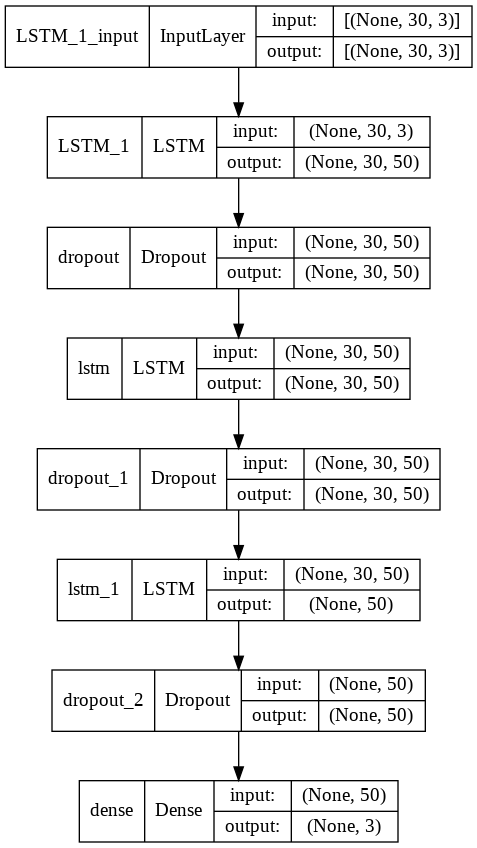

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

### 1.1.7 Model fitting

In [ ]:
EPOCHS = 10
BATCH_SIZE = 32
history = model.fit(train_features, train_labels, validation_data=(val_features, val_labels),epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/10
604/604 [==============================] - 35s 49ms/step - loss: 0.0211 - mean_absolute_error: 0.1012 - val_loss: 0.0113 - val_mean_absolute_error: 0.0647
Epoch 2/10
604/604 [==============================] - 28s 47ms/step - loss: 0.0133 - mean_absolute_error: 0.0798 - val_loss: 0.0083 - val_mean_absolute_error: 0.0528
Epoch 3/10
604/604 [==============================] - 28s 47ms/step - loss: 0.0104 - mean_absolute_error: 0.0705 - val_loss: 0.0064 - val_mean_absolute_error: 0.0487
Epoch 4/10
604/604 [==============================] - 28s 46ms/step - loss: 0.0088 - mean_absolute_error: 0.0646 - val_loss: 0.0058 - val_mean_absolute_error: 0.0450
Epoch 5/10
604/604 [==============================] - 28s 47ms/step - loss: 0.0078 - mean_absolute_error: 0.0597 - val_loss: 0.0055 - val_mean_absolute_error: 0.0426
Epoch 6/10
604/604 [==============================] - 28s 47ms/step - loss: 0.0073 - mean_absolute_error: 0.0570 - val_loss: 0.0051 - val_mean_absolute_error: 0.0392
Epoc

### 1.1.8 Plotting losses and metrics

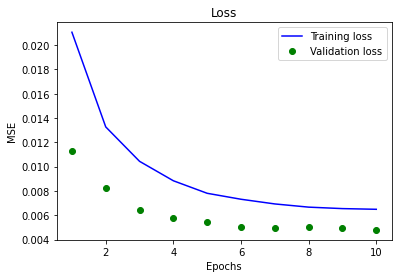

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, EPOCHS + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'go', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

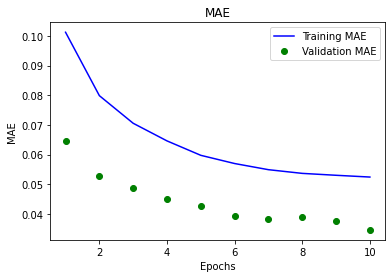

In [ ]:
mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']
epochs = range(1, EPOCHS + 1)
plt.plot(epochs, mae, 'b', label='Training MAE')
plt.plot(epochs, val_mae, 'go', label='Validation MAE')
plt.title('MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

### 1.1.9 Test evaluation
We import the test dataset, then we normalize it, preprocess it and, finally, we evaluate our model over the test dataset

x = 81.06
y = 85.26
z = 79.94

(dopo la denormalizzazione)

In [ ]:
test_data = pd.read_csv('dataset_task_1/test.csv')

normalized_test_data = scaler.fit_transform(test_data)

test_features = []
test_labels = []

for i in range(WINDOW_SIZE, len(normalized_test_data), WINDOW_SHIFT):
  test_features.append(normalized_test_data[i - WINDOW_SIZE:i])
  test_labels.append(normalized_test_data[i])
test_features, test_labels = np.array(test_features), np.array(test_labels)

model.evaluate(test_features, test_labels)

773/773 [==============================] - 9s 12ms/step - loss: 0.0061 - mean_absolute_error: 0.0442


[0.006094294600188732, 0.04420936107635498]

### 1.1.10 Test prediction
We try to predict some values to check manually how good the prediction is

In [ ]:
index = 1
print(f'expected prediction:\t{test_labels[index]}')

test = np.reshape(test_features[index], (1, test_features[index].shape[0], test_features[index].shape[1]))
print(f'actual prediction:\t{model.predict(test)[0]}')

expected prediction:	[0.79274611 0.29585799 0.15266443]
actual prediction:	[0.7850455  0.30354047 0.17014451]


## 1.2 Best window size and window shift selection 

In [ ]:
window_sizes = [
 18,  # 10 seconds sequences in 3 minutes
 24,  # 10 seconds sequences in 4 minutes
 30,  # 10 seconds sequences in 5 minutes
 36,  # 10 seconds sequences in 6 minutes
 42,  # 10 seconds sequences in 7 minutes
]

window_shifts = [
 3,  # 10  sequences in 30 seconds
 6,  # 10 seconds sequences in 1 minute
 9,  # 10 seconds sequences in 1 minute and 30 seconds
]

def features_and_labels(window_size: int = 30, window_shift: int = 6):
  WINDOW_SIZE = window_size
  WINDOW_SHIFT = window_shift

  features = []
  labels = []

  for i in range(WINDOW_SIZE, len(normalized_data), WINDOW_SHIFT):
    features.append(normalized_data[i - WINDOW_SIZE:i])
    labels.append(normalized_data[i])
  features, labels = np.array(features), np.array(labels)

  return features, labels

def build_model():
  model = models.Sequential()
  model.add(layers.LSTM(name='LSTM_1', units=50, return_sequences=True, input_shape=(features.shape[1], 3)))
  model.add(layers.Dropout(0.2))
  model.add(layers.LSTM(units=50, return_sequences=True))
  model.add(layers.Dropout(0.2))
  model.add(layers.LSTM(units=50))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(units=3))
  model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss=losses.mse, metrics=[metrics.mae])

  return model

features, labels = features_and_labels()
print(features[0])
print(labels[0])

[[0.5333626  0.8431092  0.18445647]
 [0.45346795 0.92942299 0.46138711]
 [0.48287972 0.84978541 0.20855878]
 [0.32309043 0.69623271 0.21839646]
 [0.42186128 0.82212685 0.29758977]
 [0.64925373 0.88602766 0.33989179]
 [0.24934153 0.63757749 0.38760453]
 [0.52414399 0.62708631 0.03639941]
 [0.58867428 0.62613257 0.05558288]
 [0.55048288 0.78874583 0.16232169]
 [0.60623354 0.53409633 0.0275455 ]
 [0.5452151  0.55412494 0.75946877]
 [0.4666374  0.66142108 0.80177078]
 [0.20676032 0.22508345 0.59173635]
 [0.17603161 0.24320458 0.58780128]
 [0.3595259  0.63185503 0.92769306]
 [0.35996488 0.6323319  0.92769306]
 [0.3595259  0.63280877 0.92720118]
 [0.35996488 0.63328565 0.92769306]
 [0.36040386 0.63328565 0.92769306]
 [0.36084284 0.63376252 0.92720118]
 [0.36215979 0.63471626 0.92769306]
 [0.36479368 0.63614688 0.92867683]
 [0.36523266 0.63614688 0.92867683]
 [0.36523266 0.63662375 0.92867683]
 [0.36479368 0.63662375 0.92867683]
 [0.36523266 0.63614688 0.92867683]
 [0.36479368 0.63662375 0.92

In [ ]:
history = []
for window_size in window_sizes:
  for window_shift in window_shifts:
    print(f'window_size: {window_size} - window_shift: {window_shift}')

    features, labels = features_and_labels(window_size, window_shift)
    train_features, val_features, train_labels, val_labels = train_test_split(features, labels, test_size=0.2)

    model = build_model()

    print(f'starting to fit...')
    history.append(model.fit(train_features, train_labels, validation_data=(val_features, val_labels),epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0))
    print(f'fit ended!')

window_size: 18 - window_shift: 3
starting to fit...
fit ended!
window_size: 18 - window_shift: 6
starting to fit...
fit ended!
window_size: 18 - window_shift: 9
starting to fit...
fit ended!
window_size: 24 - window_shift: 3
starting to fit...
fit ended!
window_size: 24 - window_shift: 6
starting to fit...
fit ended!
window_size: 24 - window_shift: 9
starting to fit...
fit ended!
window_size: 30 - window_shift: 3
starting to fit...
fit ended!
window_size: 30 - window_shift: 6
starting to fit...
fit ended!
window_size: 30 - window_shift: 9
starting to fit...
fit ended!
window_size: 36 - window_shift: 3
starting to fit...
fit ended!
window_size: 36 - window_shift: 6
starting to fit...
fit ended!
window_size: 36 - window_shift: 9
starting to fit...
fit ended!
window_size: 42 - window_shift: 3
starting to fit...
fit ended!
window_size: 42 - window_shift: 6
starting to fit...
fit ended!
window_size: 42 - window_shift: 9
starting to fit...
fit ended!


window_size: 18 - window_shift: 3 - loss: 0.006150060333311558 - val_loss: 0.004698697477579117 - mae: 0.050419148057699203 - val_mae: 0.03820827975869179 - 
window_size: 18 - window_shift: 6 - loss: 0.006416386924684048 - val_loss: 0.005062369629740715 - mae: 0.05228351429104805 - val_mae: 0.034966107457876205 - 
window_size: 18 - window_shift: 9 - loss: 0.006799521390348673 - val_loss: 0.00523967994377017 - mae: 0.05472688749432564 - val_mae: 0.041516102850437164 - 

window_size: 24 - window_shift: 3 - loss: 0.006416386924684048 - val_loss: 0.005062369629740715 - mae: 0.05228351429104805 - val_mae: 0.034966107457876205 - 
window_size: 24 - window_shift: 6 - loss: 0.006799521390348673 - val_loss: 0.00523967994377017 - mae: 0.05472688749432564 - val_mae: 0.041516102850437164 - 
window_size: 24 - window_shift: 9 - loss: 0.006053256336599588 - val_loss: 0.004730765242129564 - mae: 0.050139572471380234 - val_mae: 0.03496371582150459 - 

window_size: 30 - window_shift: 3 - loss: 0.00679952

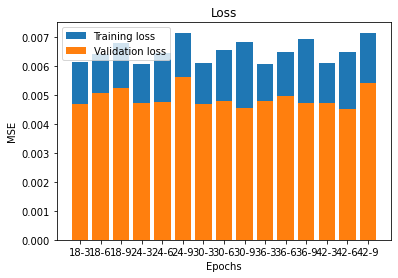

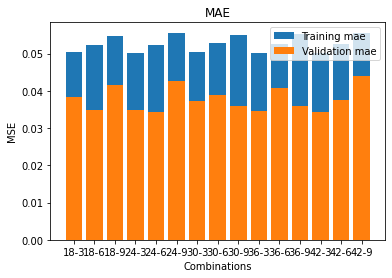

In [ ]:
losses = []
val_losses = []
maes = []
val_maes = []


for h in history:
  losses.append(h.history['loss'][EPOCHS - 1])
  val_losses.append(h.history['val_loss'][EPOCHS - 1])
  maes.append(h.history['mean_absolute_error'][EPOCHS - 1])
  val_maes.append(h.history['val_mean_absolute_error'][EPOCHS - 1])


for window_size in window_sizes:
  for window_shift in window_shifts:
    print(
        f'window_size: {window_size} - ' + 
        f'window_shift: {window_shift} - ' + 
        f'loss: {losses[window_sizes.index(window_size) + window_shifts.index(window_shift)]} - ' +
        f'val_loss: {val_losses[window_sizes.index(window_size) + window_shifts.index(window_shift)]} - ' +
        f'mae: {maes[window_sizes.index(window_size) + window_shifts.index(window_shift)]} - ' +
        f'val_mae: {val_maes[window_sizes.index(window_size) + window_shifts.index(window_shift)]} - '
        )
  print()

combinations = []
for window_size in window_sizes:
  for window_shift in window_shifts:
    combinations.append(f'{window_size}-{window_shift}')

plt.bar(combinations, losses, label='Training loss')
plt.bar(combinations, val_losses, label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

plt.bar(combinations, maes, label='Training mae')
plt.bar(combinations, val_maes, label='Validation mae')
plt.title('MAE')
plt.xlabel('Combinations')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [ ]:
#valutare tutte le combinazione in base allae predizioni